In [1]:
from multiprocessing import Pool
import tqdm
import pickle
from pathlib import Path
from contextlib import closing
from rdkit import Chem
import numpy as np
import pandas as pd

In [2]:
import sys
sys.path.append("../../")

In [3]:
%%time
fragments_path = Path("/net/cci/cschlick/Filtered_COD3/fragments.pkl")
with fragments_path.open("rb") as fh:
  fragments = pickle.load(fh)

CPU times: user 27.4 s, sys: 5.31 s, total: 32.7 s
Wall time: 32.8 s


In [4]:
results = fragments

In [5]:
N_max = -1
angle_fragments = []
bond_fragments = []
for i,result in enumerate(fragments):
  if i<N_max or N_max == -1:
    angle_fragments+=result["angle_fragments"]
    bond_fragments+=result["bond_fragments"]

In [6]:
from phenixml.featurizers.ani_featurizer import ANIFeaturizer

In [7]:
# elements and parameters
covalent_organic = ["O","C","H","N","P","S","Cl","B","F","I","Br"]
metals = ["Na","K","Ca","Fe","Mn","Zn","Mg","Cu","Co"]

params = {'radial_cutoff': 4.6,
 'radial_nu': 32,
 'radial_probes': [0.7,
                  1.4,
                  1.9,
                  2.4,
                  3.2,
                  3.8,
                  4.4],
 'angular_cutoff': 3.1,
 'angular_nu': 4,
 'angular_probes': [0.0, 1.57, 3.14, 4.71],
 'angular_radial_probes': [0.7,1.4,1.9,2.4],
 'angular_zeta': 8,
 'min_probed_value': 0.0,
 'exclude_hydrogens': False,
 'elements_considered': covalent_organic}

In [8]:
def worker_angle(result):
  featurizer = ANIFeaturizer.from_bond_angle_frags(result["angle_fragments"],params)
  if featurizer is None:
    return None
  else:
    return featurizer.featurize()

def worker_bond(result):
  featurizer = ANIFeaturizer.from_bond_angle_frags(result["bond_fragments"],params)
  if featurizer is None:
    return None
  else:
    return featurizer.featurize()


In [9]:
work = results
with closing(Pool(processes=32)) as pool:
  angle_features = []
  for result in tqdm.tqdm(pool.map(worker_angle, work), total=len(work)):
      angle_features.append(result)
  pool.terminate()

100%|██████████| 63018/63018 [00:00<00:00, 1437081.49it/s]


In [15]:
# work = results
# with closing(Pool(processes=64)) as pool:
#   bond_features = []
#   for result in tqdm.tqdm(pool.map(worker_bond, work), total=len(work)):
#       bond_features.append(result)
#   pool.terminate()

100%|██████████| 63018/63018 [00:00<00:00, 864701.12it/s]


In [16]:
N_max = -1
bond_fragments = []
X = []
for i,feature in enumerate(bond_features):
  if i<N_max or N_max ==-1:
    if feature is not None:
      bond_fragments+=results[i]["bond_fragments"]
      X.append(feature)
X = np.vstack(X)

In [17]:
X.shape

(1856810, 1133)

In [18]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split

In [19]:
mode = "bond"
if mode =="bond":

  y =  np.array([frag.properties["bond_length"] for frag in bond_fragments])
  space = np.arange(X.shape[0])
  train, test = train_test_split(space,test_size=0.2)
  frags_train, frags_test = [angle_fragments[i] for i in train], [angle_fragments[i] for i in test]
elif mode == "angle":
  X = angle_features
  y =  np.array([frag.properties["angle_deg"] for frag in angle_fragments])
  train, test = train_test_split(space,test_size=0.2)
  frags_train, frags_test = [angle_fragments[i] for i in train], [angle_fragments[i] for i in test]
  
X_train, X_test = X[train],X[test]
y_train, y_test = y[train],y[test]

In [20]:
regressor = RandomForestRegressor(n_estimators=100,min_samples_split=2, random_state=0,n_jobs=-1)

In [21]:
%%time
regressor.fit(X_train,y_train)

CPU times: user 1d 8h 28min 1s, sys: 20min 48s, total: 1d 8h 48min 50s
Wall time: 1h 10min 10s


RandomForestRegressor(n_jobs=-1, random_state=0)

In [25]:
y_pred = regressor.predict(X_test)

Text(0, 0.5, 'Predicted')

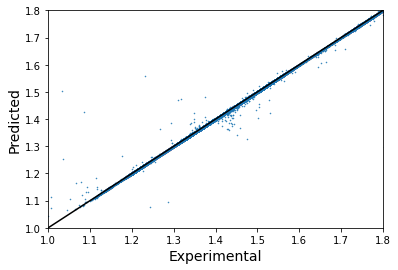

In [26]:
df = pd.DataFrame({"dists":y_test.flatten(),"pred":y_pred.flatten()})
ax = df.plot.scatter("dists","pred",s=0.25)
if mode == "bond":
  ax.set_xlim(1,1.8)
  ax.set_ylim(1,1.8)
elif mode == "angle":
  ax.set_xlim(50,140)
  ax.set_ylim(50,140)
ax.plot([0,200],[0,200],color="black")
ax.set_xlabel("Experimental",fontsize=14)
ax.set_ylabel("Predicted",fontsize=14)

In [ ]:
from sklearn.metrics import mean_squared_error
import seaborn as sns
residuals = y_test-y_pred
sns.histplot(residuals)

In [ ]:
rmse = np.sqrt(mean_squared_error(y_test,y_pred))
print("RMSE:",rmse)